### Generate Gini curve and index




In [1]:
# import packages, define correlation function for pairplots 
import numpy as np
import itertools
import math
import pandas as pd
import time
import Bio
from Bio import SeqIO
from Bio.Seq import Seq
import matplotlib
import matplotlib.pyplot as plt
from ast import literal_eval
import csv
import venn
from numpy import cov
from scipy.stats import spearmanr, pearsonr
from scipy import stats
from numpy import cov
import seaborn as sns
from itertools import islice

pd.set_option('display.max_columns', None)
sns.set(style="white")

def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)
    

In [2]:
# This information has to be input manually: File names, barcode flank sequences 

datasets = \
    {
    'NP_11_25'    : 'NP_11_25_BCCounts.csv',    # PacBio of glycerol stock
#     'NP_11_24_01' : 'NP_11_24_01_BCCounts.csv', # illumina of glycerol stock
    'NP_11_30_1_1': 'NP_11_30_1_BCCounts.csv',  # illumina of glycerol stock more reads
    'NP_11_24_10' : 'NP_11_24_10_BCCounts.csv', # Glycerol1 full aliquot outgrowth
    'NP_11_24_11' : 'NP_11_24_11_BCCounts.csv', # Glycerol2 full aliquot outgrowth
    'NP_11_24_18' : 'NP_11_24_18_BCCounts.csv', # Glycerol1 outgrowth fewer PCR steps
    'NP_11_24_19' : 'NP_11_24_19_BCCounts.csv', # Glycerol2 outgrowth fewer PCR steps
    'NP_11_27_21' : 'NP_11_27_21_BCCounts.csv', # Glycerol stock pick
    'NP_11_27_22' : 'NP_11_27_22_BCCounts.csv', # Preselection outgrowth (no aTc)
    'NP_11_27_23' : 'NP_11_27_23_BCCounts.csv', # Preselection outgrowth (with aTc)
    'NP_11_27_24' : 'NP_11_27_24_BCCounts.csv', # Selection replicate 1
    'NP_11_27_25' : 'NP_11_27_25_BCCounts.csv'  # Selection replicate 2
    }

PBlookupTable = 'NP_11_21_1_BB_AB_lookupTable.csv'
PBallBCs = 'NP_11_25'
illuminaGlycerol = 'NP_11_30_1_1'
outgrowths = list(islice(datasets,2,9))
selections = list(islice(datasets,9,11))

# Make a dataframe with all of the data (each barcode and its frequency in each dataset)
# Switch to outer merges so that all data is retained at each step

BCDF = pd.read_csv(PBlookupTable, index_col = 0).reset_index().rename(columns = {'Barcode_sequence':'Barcode'})

for experiment in datasets:
    dataDF = pd.read_csv(datasets[experiment])
    BCDF = BCDF.merge(dataDF, how = 'outer', on = 'Barcode')

In [3]:
# Get normalized enrichment values on a log scale and perform averages
    
# # # Add 0.01 to each value so that there are no errors
# # naValues = {i : 0.01 for i in listOfFileNames}
# # filledInBCDF = BCDF#.fillna(value=naValues)

# Get enrichment value
# Normalize to total reads
for experiment in datasets:
    if experiment != 'NP_11_25':
        reads = BCDF[experiment]
        totalReads = reads.sum()
        pacbioTotalReads = BCDF['NP_11_25'].sum()
        BCDF[experiment + '_norm_enrich'] = np.log((reads/totalReads)/(BCDF['NP_11_25']/pacbioTotalReads))

# Get enrichment value
# Normalize to total reads
for experiment in selections:
    BCDF[experiment + '_selection_enrich'] = BCDF[experiment + '_norm_enrich'] - BCDF['NP_11_27_23_norm_enrich']


In [4]:
# Get average and std. dev. across mutants for each replicate
# Collapse to one row per mutant in separate dataframe

mutDF = BCDF[['correctedAAmut']].drop_duplicates()
for dataset in ([illuminaGlycerol] + outgrowths + selections):
    if dataset in ([illuminaGlycerol] + outgrowths):
        column = dataset + '_norm_enrich'
    if dataset in selections:
        column = dataset + '_selection_enrich'    
    mutAvgs = BCDF.groupby(['correctedAAmut'])[column].mean().to_frame(name = dataset + '_mutAvgLog')
    mutStDevs = BCDF.groupby(['correctedAAmut'])[column].std().to_frame(name = dataset + '_mutStDevLog')
    mutDF = mutDF.merge(mutAvgs, on = 'correctedAAmut')
    mutDF = mutDF.merge(mutStDevs, on = 'correctedAAmut')
    BCDF = BCDF.merge(mutAvgs, how = 'outer', on = 'correctedAAmut')
    BCDF = BCDF.merge(mutStDevs, how = 'outer', on = 'correctedAAmut')


In [5]:
# Get average of averages, average of standard deviations as new columns
# Separate for outgrowths and selections, all barcodes and mutant

columnsToAvg = []
for experiment in outgrowths:
    columnsToAvg.append(experiment + '_norm_enrich')
BCDF['outgrowths_avg'] = BCDF[columnsToAvg].mean(axis = 1)
BCDF['outgrowths_stDev'] = BCDF[columnsToAvg].std(axis = 1)

columnsToAvg = []
for experiment in selections:
    columnsToAvg.append(experiment + '_norm_enrich')
BCDF['selections_avg'] = BCDF[columnsToAvg].mean(axis = 1)
BCDF['selections_stDev'] = BCDF[columnsToAvg].std(axis = 1)

# There are two distinct standard deviations here!

columnsToAvg = []
for experiment in outgrowths:
    columnsToAvg.append(experiment + '_mutAvgLog')
mutDF['outgrowths_mut_avg'] = mutDF[columnsToAvg].mean(axis = 1)
mutDF['outgrowths_mut_stDev'] = mutDF[columnsToAvg].std(axis = 1)
columnsToAvg = []
for experiment in outgrowths:
    columnsToAvg.append(experiment + '_mutStDevLog')
mutDF['outgrowths_mut_avg_of_rep_stDevs'] = mutDF[columnsToAvg].mean(axis = 1)

columnsToAvg = []
for experiment in selections:
    columnsToAvg.append(experiment + '_mutAvgLog')
mutDF['selections_mut_avg'] = mutDF[columnsToAvg].mean(axis = 1)
mutDF['selections_mut_stDev'] = mutDF[columnsToAvg].std(axis = 1)

columnsToAvg = []
for experiment in selections:
    columnsToAvg.append(experiment + '_mutStDevLog')
mutDF['selections_mut_avg_of_rep_stDevs'] = mutDF[columnsToAvg].mean(axis = 1)





In [6]:
# Add column for barcodes/mutation

BCsPerMut = BCDF['correctedAAmut'].value_counts().to_frame().reset_index().rename(columns = 
                                        {'index': 'correctedAAmut', 'correctedAAmut':'BCsPerMut'})
mutDF = mutDF.merge(BCsPerMut, how = 'outer', on = 'correctedAAmut')


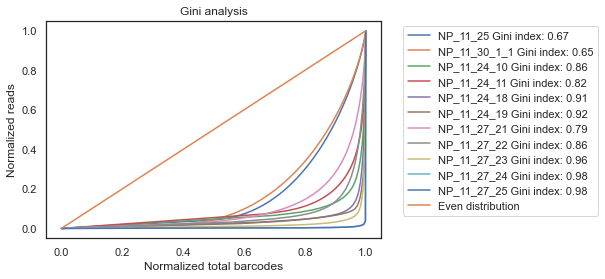

In [7]:
# Gini coefficient analysis


for dataset in datasets:
    sortedFreqs = BCDF[dataset].to_frame().sort_values(by = dataset).dropna()

    totalReads = sortedFreqs[dataset].sum()
    totalBCs = len(sortedFreqs)

    giniDataX = []
    giniDataY = []

    for subsample in range(totalBCs):
        if subsample%1000 == 0:
            giniDataX.append(subsample/totalBCs)
            giniDataY.append(sortedFreqs.iloc[:subsample][dataset].sum()/totalReads)
    giniDataX.append(1)
    giniDataY.append(1)
    
    straightLineX = np.linspace(0, 1, len(giniDataY))
    straightLineY = np.linspace(0, 1, len(giniDataY))
    
    giniIndex = 2*(np.array(giniDataX) - np.array(giniDataY)).sum()/len(giniDataY)
    label = dataset + ' Gini index: ' + str(giniIndex)[:4]
    plt.plot(giniDataX, giniDataY, label = label)
    plotEnd = giniDataX[-1]

    

plt.plot(straightLineX, straightLineY, label = 'Even distribution')
plt.xlabel('Normalized total barcodes')
plt.ylabel('Normalized reads')
plt.title('Gini analysis')
plt.legend(bbox_to_anchor=(1.05, 1))



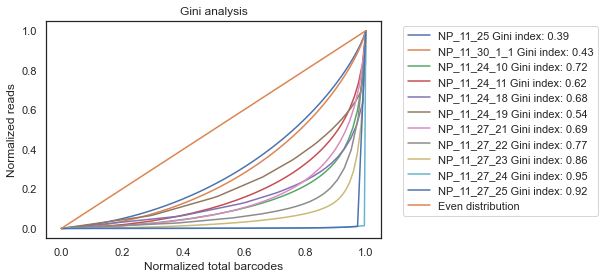

In [8]:
# Just for filtered BCs

filteredLookupTable = 'NP_11_21_1_BB_AB_lookupTable.csv'
bbMutLookup = 'NP_11_21_1_BB_AB_BBmuts_lookupTable.csv'
indelLookup = 'NP_11_21_1_BB_AB_indels_lookupTable.csv'

filterDF = pd.read_csv(filteredLookupTable, index_col = 0).reset_index().rename(columns = 
                                                {'index': 'filtered', 'Barcode_sequence':'Barcode'})
bbMutDF = pd.read_csv(bbMutLookup, index_col = 0).reset_index().rename(columns = 
                                                {'index': 'backboneMut', 'Barcode_sequence':'Barcode'})
indelDF = pd.read_csv(indelLookup, index_col = 0).reset_index().rename(columns = 
                                                {'index': 'hasIndel', 'Barcode_sequence':'Barcode'})

filterDF = filterDF.merge(BCDF, how = 'left', on = 'Barcode')
bbMutDF = bbMutDF.merge(BCDF, how = 'left', on = 'Barcode')
indelDF = indelDF.merge(BCDF, how = 'left', on = 'Barcode')


for dataset in datasets:
    sortedFreqs = filterDF[dataset].to_frame().sort_values(by = dataset).dropna()

    totalReads = sortedFreqs[dataset].sum()
    totalBCs = len(sortedFreqs)

    giniDataX = []
    giniDataY = []

    for subsample in range(totalBCs):
        if subsample%1000 == 0:
            giniDataX.append(subsample/totalBCs)
            giniDataY.append(sortedFreqs.iloc[:subsample][dataset].sum()/totalReads)
    giniDataX.append(1)
    giniDataY.append(1)
    
    straightLineX = np.linspace(0, 1, len(giniDataY))
    straightLineY = np.linspace(0, 1, len(giniDataY))
    
    giniIndex = 2*(np.array(giniDataX) - np.array(giniDataY)).sum()/len(giniDataY)
    label = dataset + ' Gini index: ' + str(giniIndex)[:4]
    plt.plot(giniDataX, giniDataY, label = label)
    plotEnd = giniDataX[-1]

    

plt.plot(straightLineX, straightLineY, label = 'Even distribution')
plt.xlabel('Normalized total barcodes')
plt.ylabel('Normalized reads')
plt.title('Gini analysis')
plt.legend(bbox_to_anchor=(1.05, 1))